In [1]:
#!fsharp
#r "nuget: Microsoft.ML.ImageAnalytics, 1.5.2"
#r "nuget: Microsoft.ML.Vision, 1.5.2"
#r "nuget: SciSharp.TensorFlow.Redist, 2.3.1"
#r "nuget: SixLabors.ImageSharp, 1.0.2"

Installed package SixLabors.ImageSharp version 1.0.2

Installed package Microsoft.ML.Vision version 1.5.2

Installed package Microsoft.ML.ImageAnalytics version 1.5.2

Installed package SciSharp.TensorFlow.Redist version 2.3.1

In [1]:
#!fsharp
open System
open System.IO
open Microsoft.ML
open Microsoft.ML.Vision
open SixLabors.ImageSharp
open SixLabors.ImageSharp.Processing


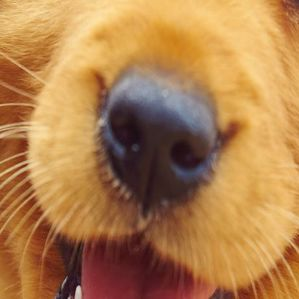

In [1]:
#!fsharp
let testImage = "/home/gregor/source/repos/IsItKrampus.NET/data/raw/dog_test_image.jpeg"
let testImageTarget = "/home/gregor/source/repos/IsItKrampus.NET/data/prepared/dog_test_image.jpg"

let cropAndResizeImage () =
    let bytes = File.ReadAllBytes testImage
    use image = Image.Load(bytes)

    let newImage =
        image.Clone(fun i ->
            i.Crop(Rectangle(734, 377, 464, 348)).Resize(299, 299)
            |> ignore)

    newImage.SaveAsJpeg(testImageTarget)

cropAndResizeImage ()

let croppedBytes = File.ReadAllBytes testImageTarget
let base64 = Convert.ToBase64String croppedBytes

DisplayFunctions.HTML $"<img src=\"data:image/jpg;base64,{base64}\"></img>"


In [1]:
#!fsharp
type ImageData =
    { ImagePath: string
      Label: string }

type ModelInput =
    { Image: byte[]
      LabelAsKey: UInt32
      Label: string
      ImagePath: string }

type ModelOutput =
    { ImagePath: string
      Label: string
      PredictedLabel: string }

In [1]:
#!fsharp
[<Literal>]
let projectRoot = "/home/gregor/source/repos/IsItKrampus.NET"

let dataDir = Path.Combine(projectRoot, "data", "prepared")
let workspaceDir = Path.Combine(projectRoot, "workspace")

In [1]:
#!fsharp
let mlContext = MLContext(1)

In [1]:
#!fsharp
let imageClassifierOptions =
    ImageClassificationTrainer.Options(FeatureColumnName = "Image",
                                       LabelColumnName = "LabelAsKey",
                                       ValidationSet = null,
                                       Arch = ImageClassificationTrainer.Architecture.InceptionV3)